In [1]:
# https://keras.io/
#!pip install -q keras
import keras

Using TensorFlow backend.


In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

In [5]:
import numpy as np
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight 
from sklearn import cross_validation

In [6]:
import matplotlib.pyplot as plt
import time, pickle
%matplotlib inline

In [7]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [8]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50
#l = 40
#num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [9]:
do_sub_sampling_of_input = False
do_data_augmentation = True
do_data_append       = False   #2X

In [10]:
# Load CIFAR10 Data

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]



In [11]:
nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [12]:
y_train[0], img_height, img_width, channel

(array([6], dtype=uint8), 32, 32, 3)

In [13]:
def draw_img(i, x_train, y_train, class_name):
    im = x_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (int(c), class_name[int(c)]))
    plt.axis('on')

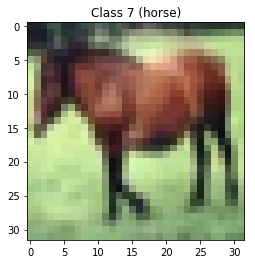

In [14]:
draw_img(7, x_train, y_train, class_name)

### Helper functions to dispaly and analyze data

These helper functions

plot_confusion_matrix(): helps us to plot the confusion matrix. 
It is taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html. 
The same page has some sample examples on how to use this function 
cm: Confusion matrix calcualted using confusion_matrix() from sklearn.metrics <br//> classes: a list of labels for the classes we are plotting
normalize=False: True means we will plot nomalized values 
title='Confusion matrix': set the tiltle of the plot 
cmap : leave it as it is 
Example Usage:plot_confusion_matrix(cm, classes=Facial_Expressions, normalize=True, title='Test Data - Using Simple Average Ensembling ')

plot_histogram(): helps to plot the histogram of a list 
lst_data: the list whose histogtam we want to plot , 
class_labels: a list of labels for the classes we are plotting 
ylabel='None': set the y label of the plot, x label is always frequency 
title='None': set the tiltle of the plot -lst_data, class_labels, ylabel='None', title='None'

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm) #to print in text if needed

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_histogram(lst_data, class_labels, ylabel='None', title='None'):
    data = pd.Series(lst_data)
    distribution = data.value_counts(sort=False)
    y_pos = np.arange(len(class_labels))
    
    plt.bar(y_pos, distribution, align='center', alpha=0.8)
    plt.xticks(y_pos, class_labels)
    plt.ylabel(ylabel)
    plt.title(title)

In [16]:
y_classes = ['airplane', 'automobile', 'bird','cat', 'deer','dog','frog','horse','ship','truck']

In [17]:
y_train.shape

(50000, 1)

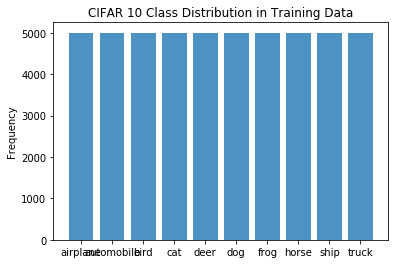

In [18]:
plot_histogram(list(y_train), y_classes, ylabel='Frequency',title='CIFAR 10 Class Distribution in Training Data')

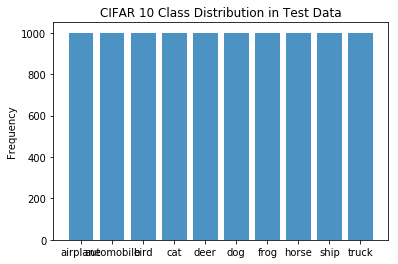

In [19]:
plot_histogram(list(y_test), y_classes, ylabel='Frequency',title='CIFAR 10 Class Distribution in Test Data')

In [20]:
# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [21]:

x_train[0][0:32][0:32][0]

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       [ 68,  54,  42],
       [ 98,  73,  52],
       [119,  91,  63],
       [139, 107,  75],
       [145, 110,  80],
       [149, 117,  89],
       [149, 120,  93],
       [131, 103,  77],
       [125,  99,  76],
       [142, 115,  91],
       [144, 112,  86],
       [137, 105,  79],
       [129,  97,  71],
       [137, 106,  79],
       [134, 106,  76],
       [124,  97,  64],
       [139, 113,  78],
       [139, 112,  75],
       [133, 105,  69],
       [136, 105,  74],
       [139, 108,  77],
       [152, 120,  89],
       [163, 131, 100],
       [168, 136, 108],
       [159, 129, 102],
       [158, 130, 104],
       [158, 132, 108],
       [152, 125, 102],
       [148, 124, 103]], dtype=uint8)

In [22]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [23]:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

mean  = np.mean(x_train, axis=(0, 1, 2), keepdims=True).astype('float32')
std   = np.std(x_train, axis=(0, 1, 2), keepdims=True).astype('float32')

mean1  = np.mean(x_test, axis=(0, 1, 2), keepdims=True).astype('float32')
std1   = np.std(x_test, axis=(0, 1, 2), keepdims=True).astype('float32')


print("Channel Mean : ", mean)
print("Channel Std : ", std)
print("Channel Mean1 : ", mean1)
print("Channel Std1 : ", std1)



x_train = (x_train - mean) / (std)
x_test  = (x_test - mean1) / (std1)

Channel Mean :  [[[[125.3069  122.95015 113.866  ]]]]
Channel Std :  [[[[62.99325  62.088604 66.70501 ]]]]
Channel Mean1 :  [[[[126.02428 123.70843 114.85442]]]]
Channel Std1 :  [[[[62.896416 61.937508 66.70607 ]]]]


In [24]:
#x_train = (x_train - 127.5)/255.0
#x_test  = (x_test  - 127.5)/255.0

In [25]:
x_train[0]

array([[[-1.0526032e+00, -9.8166406e-01, -7.6255137e-01],
        [-1.3065987e+00, -1.2393603e+00, -1.0323962e+00],
        [-1.1954757e+00, -1.2071482e+00, -1.0623789e+00],
        ...,
        [ 5.1899368e-01,  1.4575703e-01, -8.7939382e-02],
        [ 4.2374539e-01,  3.3014923e-02, -1.7788765e-01],
        [ 3.6024651e-01,  1.6908908e-02, -1.6289628e-01]],

       [[-1.7352160e+00, -1.6581167e+00, -1.4071807e+00],
        [-1.9892114e+00, -1.9802370e+00, -1.7070082e+00],
        [-1.7034665e+00, -1.8513888e+00, -1.7070082e+00],
        ...,
        [-3.6621384e-02, -5.6290764e-01, -8.8248241e-01],
        [-1.0012025e-01, -6.4343774e-01, -9.5743930e-01],
        [-5.2496098e-02, -5.7901365e-01, -8.5249966e-01]],

       [[-1.5923436e+00, -1.5936927e+00, -1.3921893e+00],
        [-1.7352160e+00, -1.8674948e+00, -1.7070082e+00],
        [-1.2113504e+00, -1.5453745e+00, -1.5870771e+00],
        ...,
        [-1.1599497e-01, -6.2733167e-01, -9.5743930e-01],
        [-8.4245533e-02, -6.2

In [26]:
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [27]:
print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


In [28]:
if do_sub_sampling_of_input:
    x_, x_train, x_, y_train    = cross_validation.train_test_split(x_train, y_train, test_size=0.25, random_state=0)
    x_, x_test,  y_, y_test    = cross_validation.train_test_split(x_test, y_test, test_size=0.25, random_state=0)
    print("After SubSampling")
    print(x_train.shape, x_test.shape)
    print(y_train.shape, y_test.shape)

In [29]:
import numpy as np

if do_data_append :
    print("Doing Data Appending")
    x_train = np.append(x_train, x_train,axis=0)
    y_train = np.append(y_train, y_train,axis=0)
#print(np.append(x_train, x_train,axis=0).shape)
#print(np.append(y_train, y_train,axis=0).shape)


In [30]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 10) (10000, 10)


# Data Augmentation

In [31]:
keras.utils.Sequence
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='nearest')

In [32]:
from keras.layers import SeparableConv2D

In [33]:
# Dense Block
def add_denseblock(input, growth_rate, dropout_rate = 0.2, l = 0):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        #Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #Conv2D_1_1 = Conv2D(int(num_filter*4*compression), (1,1), use_bias=False ,padding='same')(relu)
        Conv2D_1_1 = Conv2D(int(growth_rate*4), (1,1), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_1_1 = Dropout(dropout_rate)(Conv2D_1_1)
        BatchNorm_1_1 = BatchNormalization()(Conv2D_1_1)
        relu_1_1 = Activation('relu')(BatchNorm_1_1)
        
        #Conv2D_3_3 = Conv2D(int(growth_rate), (3,3), use_bias=False ,padding='same')(relu_1_1)
        Conv2D_3_3 = SeparableConv2D(int(growth_rate), (3,3), use_bias=False ,padding='same')(relu_1_1)
        #Conv2D_3_3 = SeparableConv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu_1_1)
        #Conv2D_3_3 = SeparableConv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu_1_1)
        if dropout_rate>0:
            Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [34]:
def add_transition(input, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    num_channels = int(input.shape[-1]) #assuming it is tensor
    Conv2D_BottleNeck = Conv2D(int(num_channels*compression), (1,1), use_bias=False ,padding='same')(relu)
    
    #Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [35]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    #flat = Dropout(0.25)(flat)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [48]:
num_filter = growth_rate = 12
dropout_rate = 0.2
compression = 0.5
l = 16

dense_l= [8, 16, 20, 12]
dense_l= [12, 12, 12, 12]
dense_l= [14, 14, 14, 14]
dense_l= [16, 16, 18, 16]

input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(2*num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, growth_rate, dropout_rate, dense_l[0])
First_Transition = add_transition(First_Block, dropout_rate)

Second_Block = add_denseblock(First_Transition, growth_rate, dropout_rate, dense_l[1])
Second_Transition = add_transition(Second_Block, dropout_rate)

Third_Block = add_denseblock(Second_Transition, growth_rate, dropout_rate, dense_l[2])
Third_Transition = add_transition(Third_Block, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  growth_rate, dropout_rate, dense_l[3])
output = output_layer(Last_Block)



In [49]:
print(input.shape)
print(First_Conv2D.shape)
print(First_Block.shape, First_Block.shape[-1])
print(First_Transition.shape)

print(Second_Block.shape)
print(Second_Transition.shape)

print(Third_Block.shape)
print(Third_Transition.shape)

print(Last_Block.shape)

(?, 32, 32, 3)
(?, 32, 32, 24)
(?, 32, 32, 216) 216
(?, 16, 16, 108)
(?, 16, 16, 300)
(?, 8, 8, 150)
(?, 8, 8, 366)
(?, 4, 4, 183)
(?, 4, 4, 375)


In [50]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_285 (Conv2D)             (None, 32, 32, 24)   648         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_553 (BatchN (None, 32, 32, 24)   96          conv2d_285[0][0]                 
__________________________________________________________________________________________________
activation_553 (Activation)     (None, 32, 32, 24)   0           batch_normalization_553[0][0]    
__________________________________________________________________________________________________
conv2d_286

In [51]:
learning_rate = 0.1
epochs = 90
decay = learning_rate/epochs
decay = 0.0001

sgd = keras.optimizers.SGD(lr=learning_rate, decay=decay, momentum=0.9, nesterov=True)

In [52]:
#batch_size = 64
#clr_triangular = CyclicLR(mode='triangular', base_lr = 0.1, max_lr = 0.2, step_size = (len(x_train)* 2 * 4)/batch_size)

In [53]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer= sgd,
              metrics=['accuracy'])

In [54]:
from keras.callbacks import LearningRateScheduler
import numpy
import math

In [55]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 30.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [56]:
# learning rate schedule
def step_decay1(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epoch_drop_01 = 40
    epoch_drop_02 = epoch_drop_01 + 40
    epoch_drop_03 = epoch_drop_02 + 40
    
    if (epoch < epoch_drop_01):
        lrate = initial_lrate
    elif (epoch < epoch_drop_02):
        lrate = initial_lrate * drop
    else:
        lrate = initial_lrate * drop * drop

    return lrate

In [57]:
def on_epoch_end(self, epoch, logs=None):
    print("epoch: ", epoch,"learning rate for", K.eval(self.model.optimizer.lr))

In [58]:
lrate = LearningRateScheduler(step_decay1)

In [59]:
from keras.callbacks import ReduceLROnPlateau

reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience= 4, min_delta=0.003, verbose=1, cooldown=0, min_lr=0.001)

In [60]:
from keras.callbacks import ModelCheckpoint

In [61]:
#from google.colab import files
#filepath = file_prefix + r".best.hdf5"
filepath = "DNST_CIFAR10_Conv_09_10_final_1-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)


In [62]:
# Save the trained weights in to .h5 format
#model.save_weights("densenet_tr_03-{epoch:02d}-{val_acc:.2f}.hdf5")
#print("Saved model to disk")

In [63]:
#from google.colab import files

#files.download('DNST_model.h5')

In [64]:
from keras import backend as K
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import LearningRateScheduler

In [65]:
class AdamTracker_0(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLR: {:.6f}\n'.format(lr))
        print("start , epoch = ", epoch,", lr = ", K.eval(optimizer.lr),", decay = ",K.eval(optimizer.decay),)

In [66]:
class AdamTracker_1(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLR: {:.6f}\n'.format(lr))
        print("end, epoch = ", epoch,", lr = ", K.eval(optimizer.lr),", decay = ",K.eval(optimizer.decay),)

In [67]:
adam_lr_tracker_1 = AdamTracker_1()
adam_lr_tracker_0 = AdamTracker_0()

In [68]:
class SGDLearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLR: {:.6f}\n'.format(lr))
        print("epoch = ", epoch,", lr = ", K.eval(optimizer.lr), ", momentum = ",K.eval(optimizer.momentum),
              ", decay = ",K.eval(optimizer.decay), ", Nestrov = ",optimizer.nesterov)

In [69]:
sgd_lr_tracker = SGDLearningRateTracker()

In [70]:
callbacks_list = [checkpoint, reduce_on_plateau]

In [71]:
callbacks_list = [adam_lr_tracker_0, adam_lr_tracker_1]

In [72]:
#callbacks_list = [checkpoint, adam_lr_tracker_0, adam_lr_tracker_1, clr_triangular]

In [73]:
callbacks_list = [checkpoint, sgd_lr_tracker]

In [74]:
from keras.models import load_model

#model = load_model('densenet_tr_03-46-0.71.hdf5')
#score = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

In [75]:
len(x_train)

50000

## Call the model with the datagen, augmentation

In [78]:
batch_size = 64
epochs = 80

In [79]:
load_model_from_back = False

if load_model_from_back:
    model = load_model('--------------------')
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [ ]:
if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 2.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)    

Epoch 1/80
1563/1562 [==============================] - 379s 243ms/step - loss: 1.9980 - acc: 0.3032 - val_loss: 1.6512 - val_acc: 0.4218

Epoch 00001: val_acc improved from -inf to 0.42180, saving model to DNST_CIFAR10_Conv_09_10_final_1-01-0.4218.hdf5
epoch =  0 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/80
1563/1562 [==============================] - 304s 195ms/step - loss: 1.5858 - acc: 0.4209 - val_loss: 1.4755 - val_acc: 0.4854

Epoch 00002: val_acc improved from 0.42180 to 0.48540, saving model to DNST_CIFAR10_Conv_09_10_final_1-02-0.4854.hdf5
epoch =  1 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/80
1563/1562 [==============================] - 305s 195ms/step - loss: 1.3868 - acc: 0.4982 - val_loss: 1.4663 - val_acc: 0.5231

Epoch 00003: val_acc improved from 0.48540 to 0.52310, saving model to DNST_CIFAR10_Conv_09_10_final_1-03-0.5231.hdf5
epoch =  2 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoc

In [71]:
model.save_weights("DNST_CIFAR10_Conv_09_10_final_80_epochs_CP.hdf5")

In [72]:
model.load_weights("DNST_CIFAR10_Conv_09_10_final_80_epochs_CP.hdf5")
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 5s 499us/step
Test loss: 0.5716010042786598
Test accuracy: 0.8546


In [73]:
batch_size = 64
epochs = 20
if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 1.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)       

Epoch 1/20
782/781 [==============================] - 128s 164ms/step - loss: 0.2907 - acc: 0.8969 - val_loss: 0.5165 - val_acc: 0.8648

Epoch 00001: val_acc did not improve from 0.88120
epoch =  0 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/20
782/781 [==============================] - 128s 164ms/step - loss: 0.2875 - acc: 0.8987 - val_loss: 0.5292 - val_acc: 0.8687

Epoch 00002: val_acc did not improve from 0.88120
epoch =  1 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/20
782/781 [==============================] - 128s 164ms/step - loss: 0.2817 - acc: 0.8998 - val_loss: 0.5320 - val_acc: 0.8649

Epoch 00003: val_acc did not improve from 0.88120
epoch =  2 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/20
782/781 [==============================] - 128s 164ms/step - loss: 0.2847 - acc: 0.9007 - val_loss: 0.5291 - val_acc: 0.8646

Epoch 00004: val_acc did not improve from 0.88120
epoch =  3 , lr =  0.1 ,

In [90]:
#model.save_weights("DNST_CIFAR10_Conv_09_10_final_100_epochs_CP.hdf5") # this is ruiined now

In [89]:
model.load_weights("DNST_CIFAR10_Conv_09_10_final_80_epochs_CP.hdf5")
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

10000/10000 [==============================] - 5s 497us/step
Test loss: 0.5716010042786598
Test accuracy: 0.8546
50000/50000 [==============================] - 25s 503us/step
Train loss: 0.31507150228619574
Train accuracy: 0.9074


# 13:56 30 october, more agumentaion, 2x

In [91]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='nearest')

In [93]:
# import keras.backend as K
k.set_value(model.optimizer.lr, 0.1)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.1
0.9
1e-04
True


In [ ]:
batch_size = 192
epochs = 180
if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 3.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)  

Epoch 1/180
782/781 [==============================] - 194s 248ms/step - loss: 0.2764 - acc: 0.9020 - val_loss: 0.4597 - val_acc: 0.8784

Epoch 00001: val_acc did not improve from 0.89430
epoch =  0 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/180
782/781 [==============================] - 193s 247ms/step - loss: 0.2676 - acc: 0.9057 - val_loss: 0.5028 - val_acc: 0.8750

Epoch 00002: val_acc did not improve from 0.89430
epoch =  1 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/180
782/781 [==============================] - 193s 247ms/step - loss: 0.2644 - acc: 0.9065 - val_loss: 0.5068 - val_acc: 0.8742

Epoch 00003: val_acc did not improve from 0.89430
epoch =  2 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/180
782/781 [==============================] - 192s 246ms/step - loss: 0.2615 - acc: 0.9067 - val_loss: 0.5178 - val_acc: 0.8735

Epoch 00004: val_acc did not improve from 0.89430
epoch =  3 , lr =  0

In [76]:
batch_size = 128
epochs = 40
if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 1.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)  

Epoch 1/40
391/390 [==============================] - 81s 206ms/step - loss: 0.2320 - acc: 0.9184 - val_loss: 0.4497 - val_acc: 0.8832

Epoch 00001: val_acc did not improve from 0.88440
epoch =  0 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/40
391/390 [==============================] - 79s 202ms/step - loss: 0.2286 - acc: 0.9189 - val_loss: 0.4881 - val_acc: 0.8813

Epoch 00002: val_acc did not improve from 0.88440
epoch =  1 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/40
391/390 [==============================] - 78s 200ms/step - loss: 0.2300 - acc: 0.9179 - val_loss: 0.4785 - val_acc: 0.8820

Epoch 00003: val_acc did not improve from 0.88440
epoch =  2 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/40
391/390 [==============================] - 78s 200ms/step - loss: 0.2259 - acc: 0.9196 - val_loss: 0.4780 - val_acc: 0.8842

Epoch 00004: val_acc did not improve from 0.88440
epoch =  3 , lr =  0.1 , mom

KeyboardInterrupt: 

In [77]:
model.save_weights("DNST_CIFAR10_Conv_09_10_final_128p_epochs_CP.hdf5")

In [84]:
model.load_weights("DNST_CIFAR10_Conv_09_10_final_128p_epochs_CP.hdf5")
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

10000/10000 [==============================] - 4s 448us/step
Test loss: 0.45804361943006516
Test accuracy: 0.8894


In [85]:
import keras.backend as K
k.set_value(model.optimizer.lr, 0.05)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.05
0.9
1e-04
True


In [86]:
batch_size = 192
epochs = 110
if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 1.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list) 

Epoch 1/110
261/260 [==============================] - 65s 250ms/step - loss: 0.1965 - acc: 0.9285 - val_loss: 0.4724 - val_acc: 0.8874

Epoch 00001: val_acc did not improve from 0.89180
epoch =  0 , lr =  0.05 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/110
261/260 [==============================] - 65s 250ms/step - loss: 0.1912 - acc: 0.9324 - val_loss: 0.4680 - val_acc: 0.8873

Epoch 00002: val_acc did not improve from 0.89180
epoch =  1 , lr =  0.05 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/110
261/260 [==============================] - 66s 251ms/step - loss: 0.1902 - acc: 0.9323 - val_loss: 0.4631 - val_acc: 0.8894

Epoch 00003: val_acc did not improve from 0.89180
epoch =  2 , lr =  0.05 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/110
261/260 [==============================] - 65s 249ms/step - loss: 0.1912 - acc: 0.9319 - val_loss: 0.4667 - val_acc: 0.8882

Epoch 00004: val_acc did not improve from 0.89180
epoch =  3 , lr =  0.

In [ ]:
batch_size = 192
epochs = 100
if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 1.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)    

In [98]:
batch_size = 190
epochs = 20
if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 2.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)

Epoch 1/20
start , epoch =  0 , lr =  0.001 , decay =  0.0
527/526 [==============================] - 141s 268ms/step - loss: 0.1133 - acc: 0.9596 - val_loss: 0.3938 - val_acc: 0.9109
end, epoch =  0 , lr =  0.001 , decay =  0.0
Epoch 2/20
start , epoch =  1 , lr =  0.001 , decay =  0.0
527/526 [==============================] - 142s 269ms/step - loss: 0.1155 - acc: 0.9588 - val_loss: 0.3899 - val_acc: 0.9108
end, epoch =  1 , lr =  0.001 , decay =  0.0
Epoch 3/20
start , epoch =  2 , lr =  0.001 , decay =  0.0
527/526 [==============================] - 141s 268ms/step - loss: 0.1110 - acc: 0.9604 - val_loss: 0.4234 - val_acc: 0.9085
end, epoch =  2 , lr =  0.001 , decay =  0.0
Epoch 4/20
start , epoch =  3 , lr =  0.001 , decay =  0.0
527/526 [==============================] - 142s 269ms/step - loss: 0.1108 - acc: 0.9600 - val_loss: 0.3743 - val_acc: 0.9144
end, epoch =  3 , lr =  0.001 , decay =  0.0
Epoch 5/20
start , epoch =  4 , lr =  0.001 , decay =  0.0
527/526 [================

In [67]:
import keras.backend as K
k.set_value(model.optimizer.lr, 0.01)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.01
0.9
1e-04
True


In [68]:
batch_size = 64
epochs = 60


if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train) * 1 /batch_size),
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)    

Epoch 1/60
782/781 [==============================] - 123s 158ms/step - loss: 0.3081 - acc: 0.8911 - val_loss: 0.4591 - val_acc: 0.8653

Epoch 00001: val_acc improved from 0.86310 to 0.86530, saving model to DNST_CIFAR10_Conv_09_03-01-0.8653.hdf5
epoch =  0 , lr =  0.01 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/60
782/781 [==============================] - 124s 159ms/step - loss: 0.3000 - acc: 0.8931 - val_loss: 0.4573 - val_acc: 0.8658

Epoch 00002: val_acc improved from 0.86530 to 0.86580, saving model to DNST_CIFAR10_Conv_09_03-02-0.8658.hdf5
epoch =  1 , lr =  0.01 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/60
782/781 [==============================] - 123s 157ms/step - loss: 0.2992 - acc: 0.8929 - val_loss: 0.4548 - val_acc: 0.8669

Epoch 00003: val_acc improved from 0.86580 to 0.86690, saving model to DNST_CIFAR10_Conv_09_03-03-0.8669.hdf5
epoch =  2 , lr =  0.01 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/60
782/781 [========

In [0]:
from google.colab import drive

In [78]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [82]:
batch_size = 64
epochs = 25


if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train) * 2 /batch_size),
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)  

Epoch 1/25
1563/1562 [==============================] - 479s 306ms/step - loss: 0.3255 - acc: 0.8856 - val_loss: 0.4556 - val_acc: 0.8753

Epoch 00001: val_acc improved from -inf to 0.87530, saving model to /content/gdrive/DNST_CIFAR10_Conv_09-01-0.8753.hdf5


OSError: ignored

In [0]:
from google.colab import files

files.download('Yolo_Basic_model.h5')

In [86]:
model.save_weights("DNST_CIFAR10_Conv_09-{epoch:02d}-{val_acc:.4f}.hdf5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files
files.download('DNST_CIFAR10_Conv_09-{epoch:02d}-{val_acc:.4f}.hdf5')

In [90]:
model.save_weights("DNST_CIFAR10_Conv_09-8753.hdf5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files
files.download('DNST_CIFAR10_Conv_09-8753.hdf5')

In [0]:
callbacks_list = [reduce_lr, sgd_lr_tracker]

In [93]:
batch_size = 64
epochs = 10


if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train) * 2 /batch_size),
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)  

Epoch 1/10
1563/1562 [==============================] - 483s 309ms/step - loss: 0.3218 - acc: 0.8858 - val_loss: 0.5009 - val_acc: 0.8662
epoch =  0 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/10
1563/1562 [==============================] - 481s 308ms/step - loss: 0.3188 - acc: 0.8869 - val_loss: 0.4564 - val_acc: 0.8762
epoch =  1 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/10
1563/1562 [==============================] - 481s 308ms/step - loss: 0.3142 - acc: 0.8877 - val_loss: 0.4933 - val_acc: 0.8682
epoch =  2 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/10
1563/1562 [==============================] - 481s 308ms/step - loss: 0.3168 - acc: 0.8882 - val_loss: 0.4712 - val_acc: 0.8749
epoch =  3 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 5/10
1563/1562 [==============================] - 480s 307ms/step - loss: 0.3098 - acc: 0.8895 - val_loss: 0.4724 - val_acc: 0.8723
epoch 

In [94]:
batch_size = 64
epochs = 10


if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train) * 2 /batch_size),
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)  

Epoch 1/10
1563/1562 [==============================] - 478s 306ms/step - loss: 0.2864 - acc: 0.8983 - val_loss: 0.4615 - val_acc: 0.8770
epoch =  0 , lr =  0.05 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/10
1563/1562 [==============================] - 477s 305ms/step - loss: 0.2874 - acc: 0.8973 - val_loss: 0.4415 - val_acc: 0.8826
epoch =  1 , lr =  0.05 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/10
1563/1562 [==============================] - 475s 304ms/step - loss: 0.2812 - acc: 0.9003 - val_loss: 0.4585 - val_acc: 0.8797
epoch =  2 , lr =  0.05 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/10
1563/1562 [==============================] - 475s 304ms/step - loss: 0.2811 - acc: 0.9005 - val_loss: 0.4513 - val_acc: 0.8810
epoch =  3 , lr =  0.05 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 5/10
1563/1562 [==============================] - 477s 305ms/step - loss: 0.2795 - acc: 0.9013 - val_loss: 0.4491 - val_acc: 0.8793

E

In [95]:
model.save_weights("DNST_CIFAR10_Conv_09-8823.hdf5")
print("Saved model to disk")

Saved model to disk


In [0]:
files.download('DNST_CIFAR10_Conv_09-8823.hdf5')

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience= 4, min_delta=0.004, verbose=1, cooldown=0, min_lr=0.001)
callbacks_list = [reduce_lr, sgd_lr_tracker]

In [99]:
batch_size = 64
epochs = 10


if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train) * 2 /batch_size),
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)  

Epoch 1/10
1563/1562 [==============================] - 481s 308ms/step - loss: 0.2684 - acc: 0.9047 - val_loss: 0.4599 - val_acc: 0.8813
epoch =  0 , lr =  0.025 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/10
1563/1562 [==============================] - 486s 311ms/step - loss: 0.2674 - acc: 0.9048 - val_loss: 0.4478 - val_acc: 0.8850
epoch =  1 , lr =  0.025 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/10
1563/1562 [==============================] - 485s 311ms/step - loss: 0.2653 - acc: 0.9050 - val_loss: 0.4503 - val_acc: 0.8833
epoch =  2 , lr =  0.025 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/10
1563/1562 [==============================] - 486s 311ms/step - loss: 0.2659 - acc: 0.9053 - val_loss: 0.4546 - val_acc: 0.8836
epoch =  3 , lr =  0.025 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 5/10
1563/1562 [==============================] - 483s 309ms/step - loss: 0.2644 - acc: 0.9063 - val_loss: 0.4456 - val_acc: 0.884

In [100]:
model.save_weights("DNST_CIFAR10_Conv_09-8831.hdf5")
print("Saved model to disk")
files.download('DNST_CIFAR10_Conv_09-8831.hdf5')

Saved model to disk


## Restarting from GC - Epochs done: 

In [121]:
learning_rate = 0.1
epochs = 90
decay = learning_rate/epochs
decay = 0.0001

sgd = keras.optimizers.SGD(lr=learning_rate, decay=decay, momentum=0.9, nesterov=True)

In [122]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer= sgd,
              metrics=['accuracy'])

In [123]:
load_model_from_back = True

if load_model_from_back:
    model.load_weights('DNST_CIFAR10_Conv_09-8831.hdf5')
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

10000/10000 [==============================] - 8s 811us/step
Test loss: 0.4537913758456707
Test accuracy: 0.8831


In [124]:
import keras.backend as K
k.set_value(model.optimizer.lr, 0.01)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.01
0.9
1e-04
True


In [125]:
batch_size = 64
clr_triangular = CyclicLR(mode='triangular2', base_lr = 0.008, max_lr = 0.025, step_size = (len(x_train)* 2 * 5)/batch_size)

In [126]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience= 5, min_delta=0.002, verbose=1, cooldown=0, min_lr=0.001)
callbacks_list = [checkpoint, sgd_lr_tracker]

In [127]:
keras.utils.Sequence
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='nearest')

In [128]:
batch_size = 64
epochs = 50


if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train) * 2 /batch_size),
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)  

Epoch 1/50
1563/1562 [==============================] - 247s 158ms/step - loss: 0.2804 - acc: 0.9015 - val_loss: 0.4936 - val_acc: 0.8746

Epoch 00001: val_acc did not improve from 0.88620
epoch =  0 , lr =  0.01 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/50
1563/1562 [==============================] - 225s 144ms/step - loss: 0.2812 - acc: 0.8998 - val_loss: 0.4642 - val_acc: 0.8795

Epoch 00002: val_acc did not improve from 0.88620
epoch =  1 , lr =  0.01 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/50
1563/1562 [==============================] - 225s 144ms/step - loss: 0.2753 - acc: 0.9020 - val_loss: 0.4753 - val_acc: 0.8812

Epoch 00003: val_acc did not improve from 0.88620
epoch =  2 , lr =  0.01 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/50
1563/1562 [==============================] - 224s 143ms/step - loss: 0.2727 - acc: 0.9017 - val_loss: 0.4598 - val_acc: 0.8861

Epoch 00004: val_acc did not improve from 0.88620
epoch =  3 , 

In [97]:
import keras.backend as K
k.set_value(model.optimizer.lr, 0.025)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.025
0.9
1e-04
True


In [0]:
import keras.backend as K
k.set_value(model.optimizer.lr, 0.05)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.05
0.9
0.0011111111
True


In [0]:
batch_size = 64
epochs = 15


if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train) * 2 /batch_size),
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)    

Epoch 1/15
1563/1562 [==============================] - 561s 359ms/step - loss: 0.8322 - acc: 0.7061 - val_loss: 0.9455 - val_acc: 0.6963

Epoch 00001: val_acc improved from 0.69460 to 0.69630, saving model to DNST_CIFAR10_Conv_04-01-0.6963.hdf5
Epoch 2/15
1563/1562 [==============================] - 564s 361ms/step - loss: 0.8273 - acc: 0.7075 - val_loss: 0.9425 - val_acc: 0.6957

Epoch 00002: val_acc did not improve from 0.69630
Epoch 3/15
1563/1562 [==============================] - 562s 360ms/step - loss: 0.8265 - acc: 0.7071 - val_loss: 0.9484 - val_acc: 0.6992

Epoch 00003: val_acc improved from 0.69630 to 0.69920, saving model to DNST_CIFAR10_Conv_04-03-0.6992.hdf5
Epoch 4/15
1563/1562 [==============================] - 562s 360ms/step - loss: 0.8223 - acc: 0.7102 - val_loss: 0.9854 - val_acc: 0.6874

Epoch 00004: val_acc did not improve from 0.69920
Epoch 5/15
1563/1562 [==============================] - 564s 361ms/step - loss: 0.8192 - acc: 0.7084 - val_loss: 0.9261 - val_acc:

KeyboardInterrupt: 

In [0]:
#Let's see what Adam can do here
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [0]:
batch_size = 64
epochs = 15


if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train) * 2 /batch_size),
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)    

Epoch 1/15
1563/1562 [==============================] - 805s 515ms/step - loss: 0.9252 - acc: 0.6718 - val_loss: 0.9238 - val_acc: 0.6961

Epoch 00001: val_acc did not improve from 0.70730
Epoch 2/15
1563/1562 [==============================] - 685s 438ms/step - loss: 0.8538 - acc: 0.6967 - val_loss: 0.9833 - val_acc: 0.6929

Epoch 00002: val_acc did not improve from 0.70730
Epoch 3/15
1563/1562 [==============================] - 684s 438ms/step - loss: 0.7890 - acc: 0.7196 - val_loss: 0.8938 - val_acc: 0.7204

Epoch 00003: val_acc improved from 0.70730 to 0.72040, saving model to DNST_CIFAR10_Conv_04-03-0.7204.hdf5
Epoch 4/15
1563/1562 [==============================] - 688s 440ms/step - loss: 0.7361 - acc: 0.7415 - val_loss: 0.7951 - val_acc: 0.7475

Epoch 00004: val_acc improved from 0.72040 to 0.74750, saving model to DNST_CIFAR10_Conv_04-04-0.7475.hdf5
Epoch 5/15
1563/1562 [==============================] - 685s 438ms/step - loss: 0.6885 - acc: 0.7583 - val_loss: 0.8537 - val_acc:

KeyboardInterrupt: 

In [0]:
batch_size = 64
model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    steps_per_epoch= len(x_train)/batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/20
391/390 [==============================] - 78s 199ms/step - loss: 1.3040 - acc: 0.5284 - val_loss: 1.6906 - val_acc: 0.4920

Epoch 00001: val_acc did not improve from 0.52840
Epoch 2/20
391/390 [==============================] - 77s 197ms/step - loss: 1.2827 - acc: 0.5393 - val_loss: 1.5553 - val_acc: 0.5072

Epoch 00002: val_acc did not improve from 0.52840
Epoch 3/20
391/390 [==============================] - 77s 196ms/step - loss: 1.2592 - acc: 0.5477 - val_loss: 2.0982 - val_acc: 0.4572

Epoch 00003: val_acc did not improve from 0.52840
Epoch 4/20
391/390 [==============================] - 77s 197ms/step - loss: 1.2321 - acc: 0.5524 - val_loss: 1.7296 - val_acc: 0.5060

Epoch 00004: val_acc did not improve from 0.52840
Epoch 5/20
391/390 [==============================] - 77s 198ms/step - loss: 1.2145 - acc: 0.5609 - val_loss: 1.4300 - val_acc: 0.5360

Epoch 00005: val_acc improved from 0.52840 to 0.53600, saving model to densenet_tr_04_tr_10_-05-0.5360.hdf5
Epoch 6/20
3

In [0]:
from keras.backend import eval
print(eval(model.optimizer.lr))
print(eval(model.optimizer.momentum))
print(eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.05
0.9
1e-04
True


In [0]:
import keras.backend as K
k.set_value(model.optimizer.lr, 0.001)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.001
0.9
1e-04
True


In [0]:
import keras.backend as K

In [0]:
k.set_value(model.optimizer.lr, 0.001)

In [0]:
print(eval(model.optimizer.lr))
print(eval(model.optimizer.momentum))
print(eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.001
0.0
0.0
False


In [0]:
model = load_model('densenet_tr_04_tr_10_tr_05_-10-0.8099.hdf5')
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 23s 2ms/step
Test loss: 0.6240345459699631
Test accuracy: 0.8099


In [0]:
batch_size = 64
epochs = 40

if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= len(x_train)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)  

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 340s 7ms/step - loss: 0.3626 - acc: 0.8698 - val_loss: 0.6486 - val_acc: 0.7991

Epoch 00001: val_acc improved from -inf to 0.79910, saving model to densenet_tr_04_tr_10_tr_05_1_-01-0.7991.hdf5
Epoch 2/40
50000/50000 [==============================] - 279s 6ms/step - loss: 0.3594 - acc: 0.8692 - val_loss: 0.7186 - val_acc: 0.7837

Epoch 00002: val_acc did not improve from 0.79910
Epoch 3/40
50000/50000 [==============================] - 279s 6ms/step - loss: 0.3546 - acc: 0.8725 - val_loss: 0.7258 - val_acc: 0.7852

Epoch 00003: val_acc did not improve from 0.79910
Epoch 4/40
50000/50000 [==============================] - 279s 6ms/step - loss: 0.3464 - acc: 0.8765 - val_loss: 0.7185 - val_acc: 0.7932

Epoch 00004: val_acc did not improve from 0.79910
Epoch 5/40
50000/50000 [==============================] - 279s 6ms/step - loss: 0.3459 - acc: 0.8754 - val_loss: 0.6642 - val_acc: 

KeyboardInterrupt: 

In [0]:
batch_size = 64
model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    steps_per_epoch= len(x_train)/batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/100
391/390 [==============================] - 77s 197ms/step - loss: 0.9873 - acc: 0.6482 - val_loss: 1.5091 - val_acc: 0.5736

Epoch 00001: val_acc did not improve from 0.62840
Epoch 2/100
391/390 [==============================] - 77s 197ms/step - loss: 0.9468 - acc: 0.6603 - val_loss: 1.4757 - val_acc: 0.5832

Epoch 00002: val_acc did not improve from 0.62840
Epoch 3/100
391/390 [==============================] - 77s 198ms/step - loss: 0.9335 - acc: 0.6675 - val_loss: 1.5189 - val_acc: 0.5756

Epoch 00003: val_acc did not improve from 0.62840
Epoch 4/100
391/390 [==============================] - 77s 197ms/step - loss: 0.9362 - acc: 0.6618 - val_loss: 1.5160 - val_acc: 0.5780

Epoch 00004: val_acc did not improve from 0.62840
Epoch 5/100
391/390 [==============================] - 77s 197ms/step - loss: 0.9352 - acc: 0.6661 - val_loss: 1.5022 - val_acc: 0.5812

Epoch 00005: val_acc did not improve from 0.62840
Epoch 6/100
391/390 [==============================] - 77s 197ms/

In [0]:
batch_size = 64
model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    steps_per_epoch= len(x_train)/batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/10
1563/1562 [==============================] - 255s 163ms/step - loss: 0.5237 - acc: 0.8196 - val_loss: 0.6589 - val_acc: 0.8140

Epoch 00001: val_acc did not improve from 0.82030
Epoch 2/10
1563/1562 [==============================] - 256s 164ms/step - loss: 0.5276 - acc: 0.8189 - val_loss: 0.6505 - val_acc: 0.8163

Epoch 00002: val_acc did not improve from 0.82030
Epoch 3/10
1563/1562 [==============================] - 256s 164ms/step - loss: 0.5225 - acc: 0.8208 - val_loss: 0.6414 - val_acc: 0.8199

Epoch 00003: val_acc did not improve from 0.82030
Epoch 4/10
1563/1562 [==============================] - 256s 164ms/step - loss: 0.5222 - acc: 0.8207 - val_loss: 0.6389 - val_acc: 0.8188

Epoch 00004: val_acc did not improve from 0.82030
Epoch 5/10
1563/1562 [==============================] - 256s 164ms/step - loss: 0.5204 - acc: 0.8206 - val_loss: 0.6248 - val_acc: 0.8219

Epoch 00005: val_acc improved from 0.82030 to 0.82190, saving model to densenet_tr_04_tr_02_-05-0.8219.hd

In [0]:
print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)
	   
import keras.backend as K
k.set_value(model.optimizer.lr, 0.001)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.005
0.0
0.0
False
0.001
0.0
0.0
False


In [0]:
model = load_model('densenet_tr_04_tr_02_-09-0.8287.hdf5')
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 10s 1ms/step
Test loss: 0.5989693383455277
Test accuracy: 0.8287


In [0]:
batch_size = 64
model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    steps_per_epoch= len(x_train)/batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/20
1563/1562 [==============================] - 274s 175ms/step - loss: 0.5161 - acc: 0.8219 - val_loss: 0.6120 - val_acc: 0.8280

Epoch 00001: val_acc did not improve from 0.82870
Epoch 2/20
1563/1562 [==============================] - 257s 165ms/step - loss: 0.5163 - acc: 0.8214 - val_loss: 0.6226 - val_acc: 0.8244

Epoch 00002: val_acc did not improve from 0.82870
Epoch 3/20
1563/1562 [==============================] - 258s 165ms/step - loss: 0.5158 - acc: 0.8217 - val_loss: 0.6149 - val_acc: 0.8269

Epoch 00003: val_acc did not improve from 0.82870
Epoch 4/20
1563/1562 [==============================] - 258s 165ms/step - loss: 0.5113 - acc: 0.8234 - val_loss: 0.5930 - val_acc: 0.8318

Epoch 00004: val_acc improved from 0.82870 to 0.83180, saving model to densenet_tr_04_tr_02_-04-0.8318.hdf5
Epoch 5/20
1563/1562 [==============================] - 259s 166ms/step - loss: 0.5120 - acc: 0.8245 - val_loss: 0.6026 - val_acc: 0.8269

Epoch 00005: val_acc did not improve from 0.831

KeyboardInterrupt: 

In [0]:
#densenet_tr_04-26-0.82.hdf5
model = load_model('densenet_tr_04_tr_02_-04-0.8318.hdf5')
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 12s 1ms/step
Test loss: 0.5930212475657463
Test accuracy: 0.8318


In [0]:
print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)
 
import keras.backend as K
k.set_value(model.optimizer.lr, 0.0001)
k.set_value(model.optimizer.momentum, 0.9)
k.set_value(model.optimizer.decay, 0.0001)
model.optimizer.nesterov= True

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

1e-04
0.9
1e-04
False
1e-04
0.9
1e-04
True


In [0]:
batch_size = 64
model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    steps_per_epoch= len(x_train)/batch_size,
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/5
1563/1562 [==============================] - 276s 177ms/step - loss: 0.5099 - acc: 0.8240 - val_loss: 0.6481 - val_acc: 0.8179

Epoch 00001: val_acc did not improve from 0.83180
Epoch 2/5
1563/1562 [==============================] - 260s 166ms/step - loss: 0.5094 - acc: 0.8238 - val_loss: 0.6091 - val_acc: 0.8262

Epoch 00002: val_acc did not improve from 0.83180
Epoch 3/5
1563/1562 [==============================] - 258s 165ms/step - loss: 0.5118 - acc: 0.8218 - val_loss: 0.6109 - val_acc: 0.8270

Epoch 00003: val_acc did not improve from 0.83180
Epoch 4/5
1563/1562 [==============================] - 258s 165ms/step - loss: 0.5105 - acc: 0.8240 - val_loss: 0.6249 - val_acc: 0.8213

Epoch 00004: val_acc did not improve from 0.83180
Epoch 5/5
1563/1562 [==============================] - 258s 165ms/step - loss: 0.5074 - acc: 0.8249 - val_loss: 0.6098 - val_acc: 0.8290

Epoch 00005: val_acc did not improve from 0.83180


In [0]:
model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/5
782/782 [==============================] - 421s 538ms/step - loss: 0.9375 - acc: 0.6674 - val_loss: 2.1078 - val_acc: 0.5434

Epoch 00001: val_acc did not improve from 0.65110
Epoch 2/5
782/782 [==============================] - 421s 538ms/step - loss: 0.9306 - acc: 0.6690 - val_loss: 1.4070 - val_acc: 0.6178

Epoch 00002: val_acc did not improve from 0.65110
Epoch 3/5
782/782 [==============================] - 421s 538ms/step - loss: 0.9196 - acc: 0.6729 - val_loss: 1.3154 - val_acc: 0.6440

Epoch 00003: val_acc did not improve from 0.65110
Epoch 4/5
782/782 [==============================] - 421s 538ms/step - loss: 0.9123 - acc: 0.6767 - val_loss: 1.2812 - val_acc: 0.6265

Epoch 00004: val_acc did not improve from 0.65110
Epoch 5/5
782/782 [==============================] - 421s 538ms/step - loss: 0.8984 - acc: 0.6816 - val_loss: 1.3735 - val_acc: 0.6261

Epoch 00005: val_acc did not improve from 0.65110


In [0]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 218s 4ms/step - loss: 0.5481 - acc: 0.8068 - val_loss: 0.8859 - val_acc: 0.7329

Epoch 00001: val_acc improved from -inf to 0.73290, saving model to densenet-01-0.73.hdf5
Epoch 2/50
50000/50000 [==============================] - 218s 4ms/step - loss: 0.5417 - acc: 0.8087 - val_loss: 0.7878 - val_acc: 0.7589

Epoch 00002: val_acc improved from 0.73290 to 0.75890, saving model to densenet-02-0.76.hdf5
Epoch 3/50
50000/50000 [==============================] - 218s 4ms/step - loss: 0.5372 - acc: 0.8082 - val_loss: 0.7391 - val_acc: 0.7770

Epoch 00003: val_acc improved from 0.75890 to 0.77700, saving model to densenet-03-0.78.hdf5
Epoch 4/50
50000/50000 [==============================] - 218s 4ms/step - loss: 0.5322 - acc: 0.8104 - val_loss: 0.7139 - val_acc: 0.7774

Epoch 00004: val_acc improved from 0.77700 to 0.77740, saving model to densenet-04-0.78.hdf5
Epoch 5/50
21248/50000 [=

In [0]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 218s 4ms/step - loss: 0.3575 - acc: 0.8739 - val_loss: 0.7500 - val_acc: 0.7998

Epoch 00001: val_acc did not improve from 0.81130
Epoch 2/50
50000/50000 [==============================] - 218s 4ms/step - loss: 0.3542 - acc: 0.8761 - val_loss: 0.7343 - val_acc: 0.7993

Epoch 00002: val_acc did not improve from 0.81130
Epoch 3/50
50000/50000 [==============================] - 218s 4ms/step - loss: 0.3531 - acc: 0.8749 - val_loss: 0.6764 - val_acc: 0.8116

Epoch 00003: val_acc improved from 0.81130 to 0.81160, saving model to densenet-03-0.81.hdf5
Epoch 4/50
50000/50000 [==============================] - 218s 4ms/step - loss: 0.3472 - acc: 0.8772 - val_loss: 0.7236 - val_acc: 0.8018

Epoch 00004: val_acc did not improve from 0.81160
Epoch 5/50
50000/50000 [==============================] - 218s 4ms/step - loss: 0.3487 - acc: 0.8770 - val_loss: 0.7087 - val_acc: 0.8135

Epoch 00005: